In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

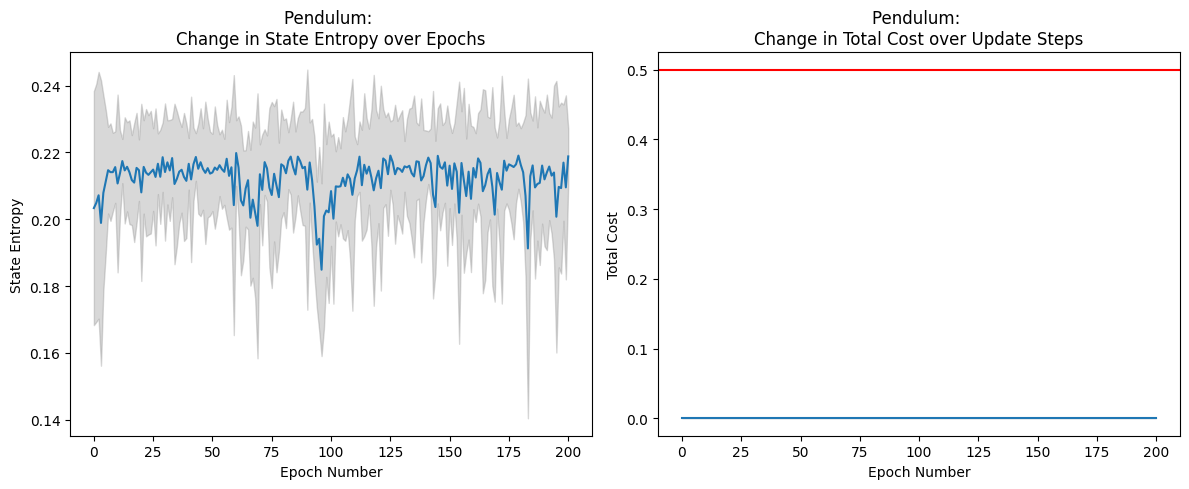

In [3]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/Pendulum/CEM/Pendulum-v1.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Pendulum: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
# plt.axhline(y=10, color="red")
ax[1].set_title("Pendulum: \nChange in Total Cost over Update Steps")

fig.tight_layout()

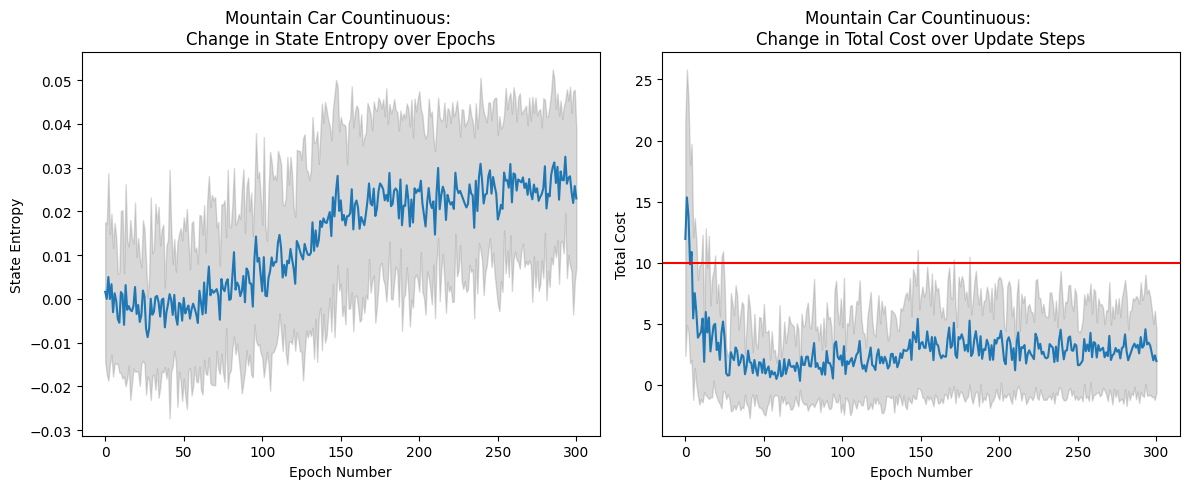

In [7]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/MountainCarContinuous/CEM/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
# plt.axhline(y=0.5, color="red")
plt.axhline(y=10, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Update Steps")

fig.tight_layout()

<Axes: xlabel='epoch', ylabel='mean_entropy'>

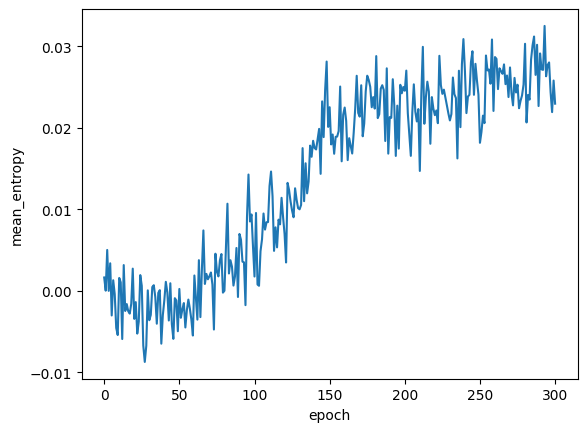

In [3]:
sns.lineplot(data=df, x="epoch", y="mean_entropy")

<Axes: xlabel='epoch', ylabel='advantage'>

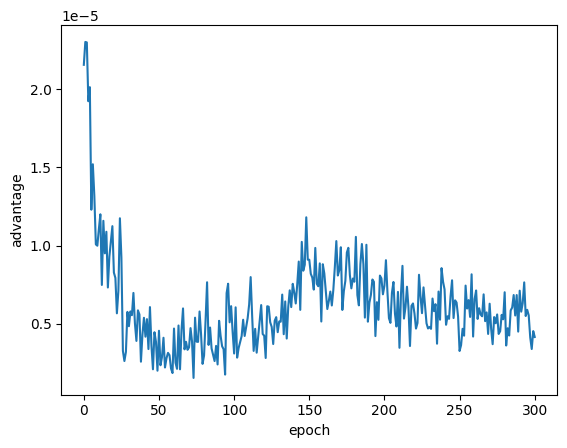

In [4]:
sns.lineplot(data=df, x="epoch", y="advantage")

<Axes: >

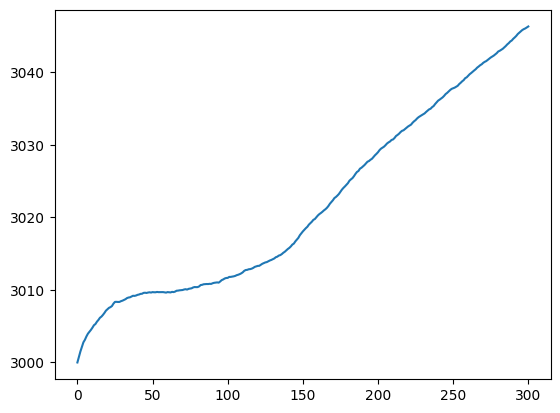

In [5]:
df["safety_weight"].plot()

<Axes: >

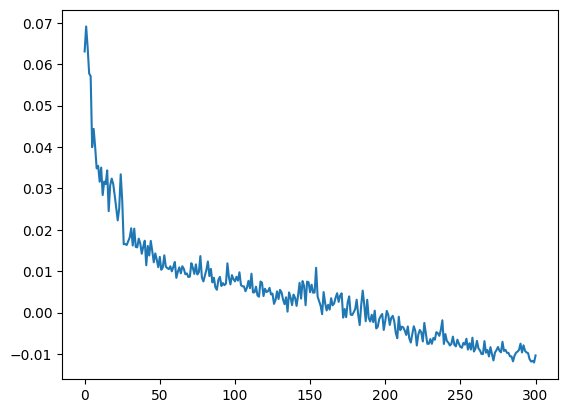

In [6]:
df["policy_loss"].plot()

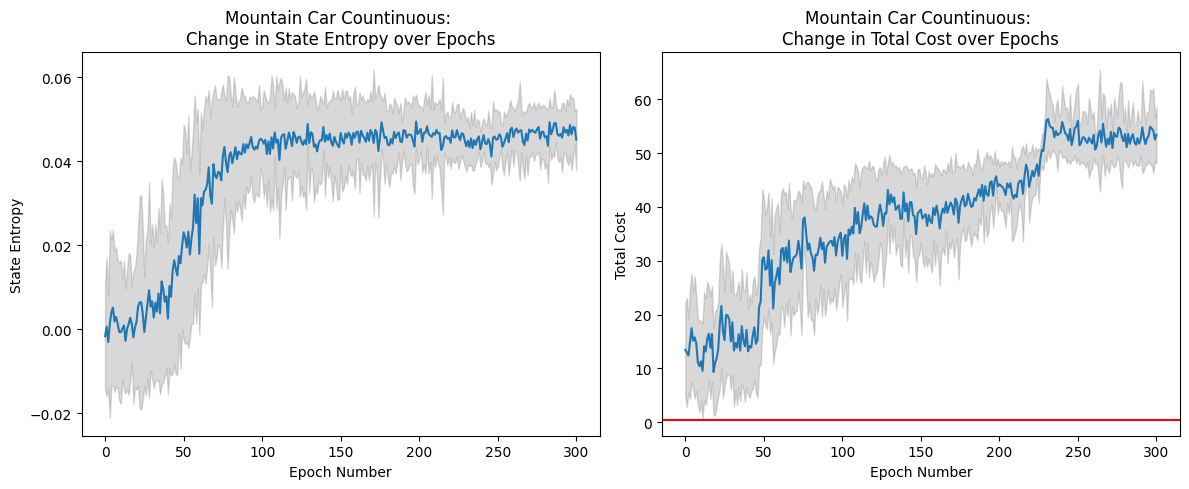

In [5]:
df = pd.read_csv("results/MountainCarContinuous/MEPOL/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Epochs")

fig.tight_layout()

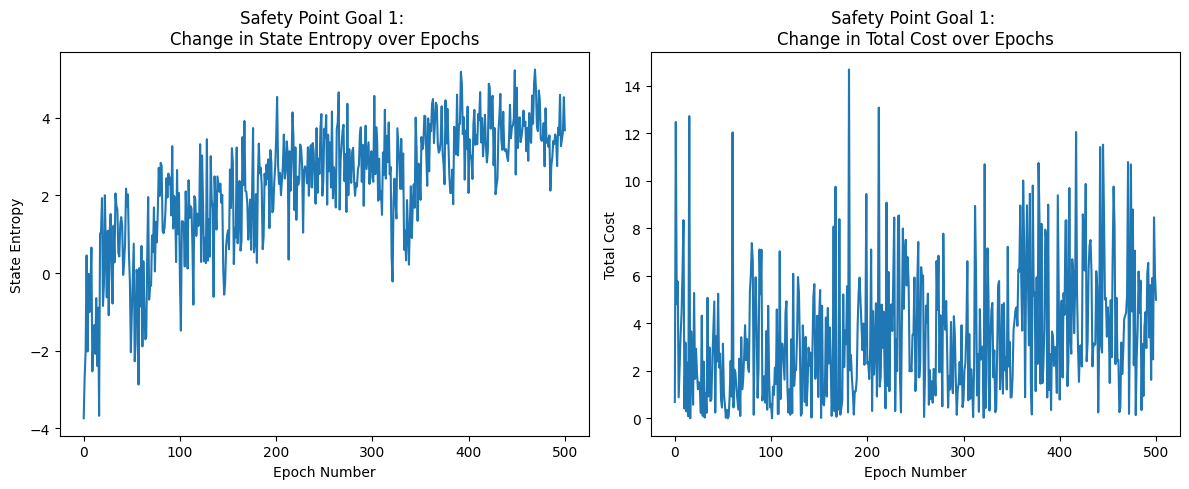

In [ ]:
df = pd.read_csv("results/SafetyPointGoal1/MEPOL/SafetyPointGoal1-v0.csv", index_col = False)
df["cost"] = abs(df["cost"])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].set_title("Safety Point Goal 1: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].set_title("Safety Point Goal 1: \nChange in Total Cost over Epochs")

fig.tight_layout()